# Effective depth results across different datasets

In [1]:
import torch

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
models = [
    # deepseek models
    "DeepSeek-R1-Distill-Qwen-1.5B",
    "DeepSeek-R1-Distill-Qwen-7B",
    "DeepSeek-R1-Distill-Qwen-14B",
    "DeepSeek-R1-Distill-Qwen-32B",
    
    # qwen models
    "Qwen2.5-1.5B-Instruct",
    "Qwen2.5-7B-Instruct",
    "Qwen2.5-14B-Instruct",
    "Qwen2.5-32B-Instruct",
    "Qwen2.5-Math-1.5B",
    "Qwen2.5-Math-7B",
    "Qwen2.5-14B",
    "Qwen2.5-32B"
]

## 1. relative norm contribution & cosine similarity

In [4]:
plt.rcParams['font.family'] = ['DejaVu Serif']
# plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'

In [5]:
def sort_zorder(bars):
    for group in zip(*[container for container in bars]):
        # 'group' is a tuple of bar objects at one x position from different groups.
        z = len(group)
        # Sort the bars by height (lowest first).
        for bar in sorted(group, key=lambda b: abs(b.get_height())):
            bar.set_zorder(z)
            z -= 1

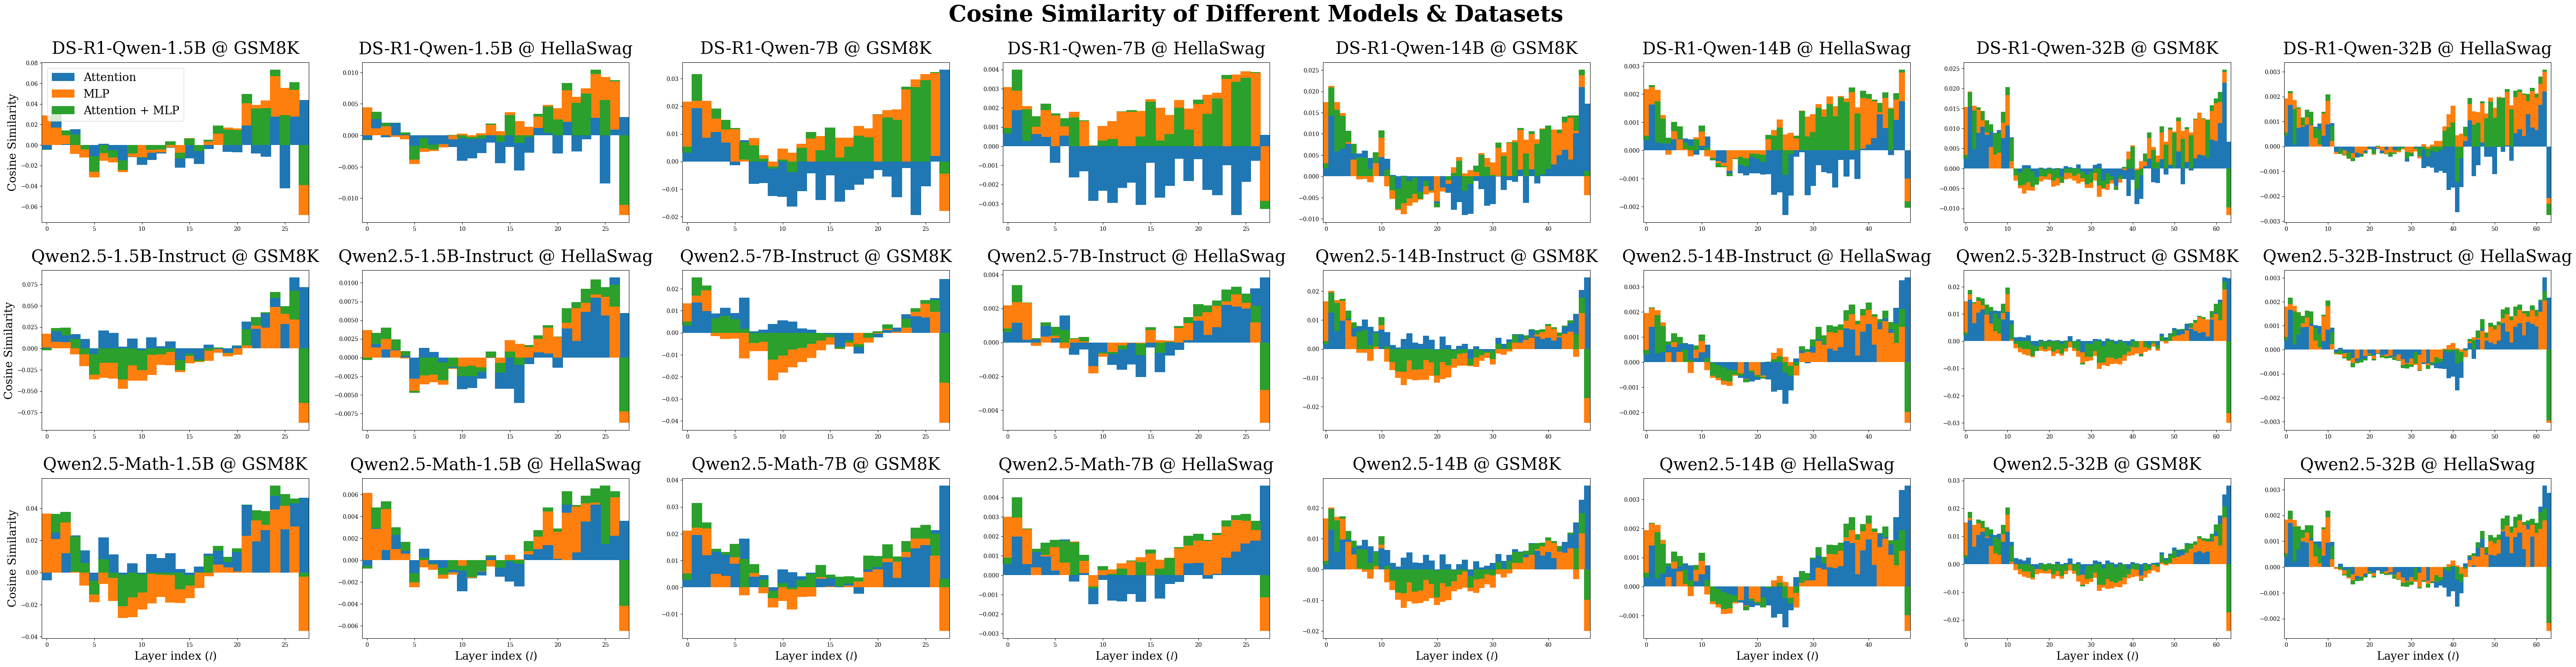

In [13]:
fig, axes = plt.subplots(3, 8, figsize=(80, 18))

# Adjust spacing parameters - these are the key changes
plt.subplots_adjust(
    top=0.9,    # 90% of the figure height for content (leaves space for suptitle)
    hspace=0.3,  # Increased vertical space between subplots
    wspace=0.2   # Horizontal space between subplots
)

idx = 0
for model in models:
    for dataset in ["gsm8k", "hellaswag"]:
        # load data
        model_path = f"outputs/{dataset}/{model}/relative_contribution.pt"
        data = torch.load(model_path)
        att_cos = data["att_cos"]
        mlp_cos = data["mlp_cos"]
        layer_cos = data["layer_cos"]
        
        # Get the current subplot axis
        ax = axes[idx//8, idx%8]
        
        # Plot the bars
        bars = []
        bars.append(ax.bar(range(len(att_cos)), att_cos.float().cpu().numpy(), label="Attention", width=1.1))
        bars.append(ax.bar(range(len(mlp_cos)), mlp_cos.float().cpu().numpy(), label="MLP", width=1.1))
        bars.append(ax.bar(range(len(layer_cos)), layer_cos.float().cpu().numpy(), label="Attention + MLP", width=1.1))
        
        # Sort z-order
        for group in zip(*[container for container in bars]):
            z = len(group)
            for bar in sorted(group, key=lambda b: abs(b.get_height())):
                bar.set_zorder(z)
                z -= 1
        
        # Set subplot title and labels
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        if model.startswith("DeepSeek-R1-Distill"):
            model_name = model.replace("DeepSeek-R1-Distill-", "DS-R1-")
        else:
            model_name = model
        if dataset == "gsm8k":
            dataset_name = "GSM8K"
        elif dataset == "hellaswag":
            dataset_name = "HellaSwag"
            
        ax.set_title(f"{model_name} @ {dataset_name}", pad=15, fontsize=30)  # Added pad to subplot titles
        ax.set_xlim(-0.5, len(att_cos)-0.5)
        if idx// 8 == 2:  # Last row
            ax.set_xlabel("Layer index ($l$)", fontsize=20)
        if idx % 8 == 0:  # First column
            ax.set_ylabel("Cosine Similarity", fontsize=20)

        # Only show legend for the first subplot to avoid repetition
        if idx == 0:
            ax.legend(fontsize=20, loc='upper left')
            
        idx += 1

# set title for the entire figure
fig.suptitle("Cosine Similarity of Different Models & Datasets", fontweight="bold", fontsize=40, y=0.98)  # Adjusted y position
fig.savefig("figures/gsm8k_hellaswag_cosine_similarity.pdf", bbox_inches='tight', dpi=300)

## 2. The effects of the layer on future computations

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

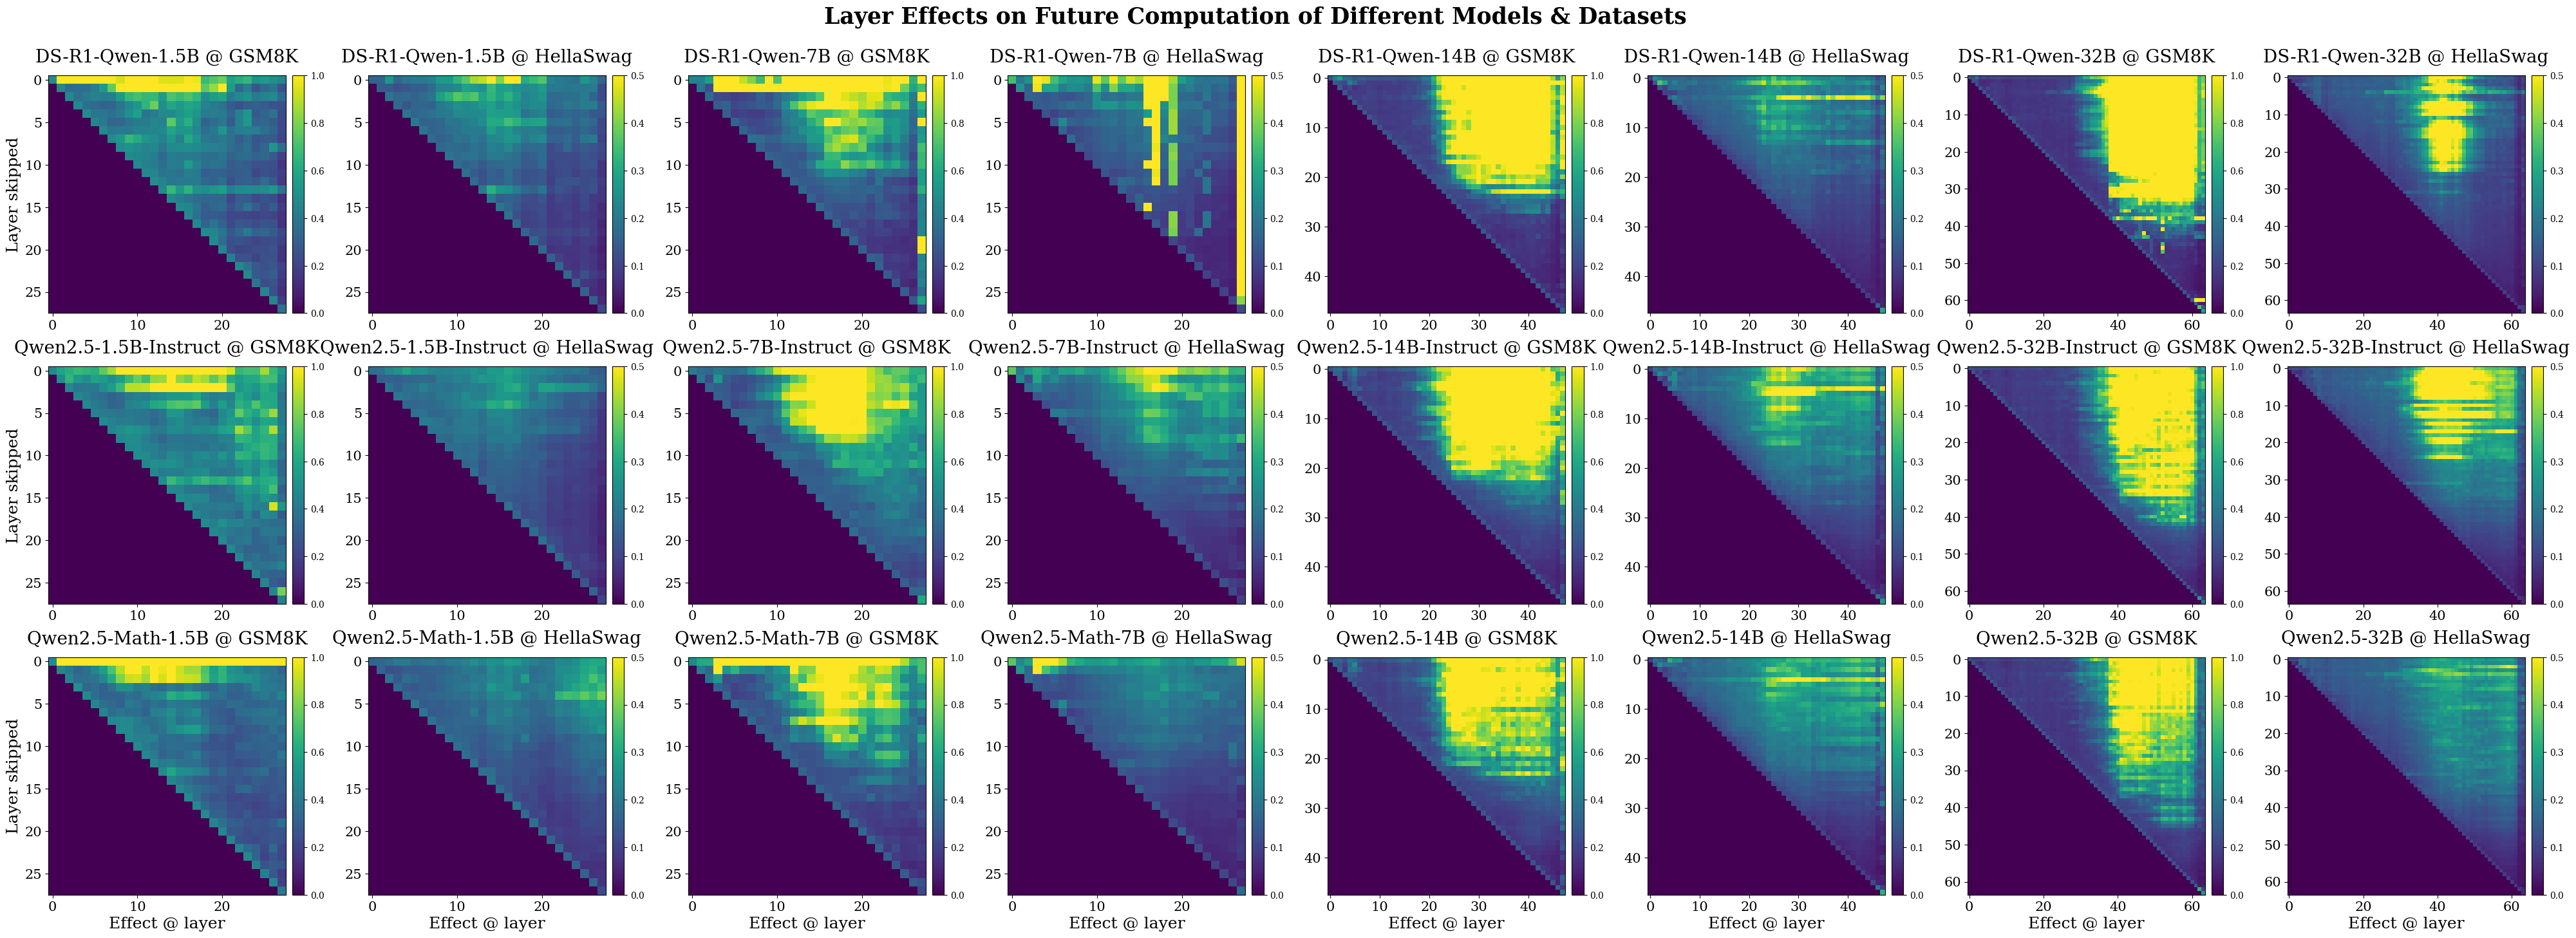

In [23]:
# Create figure for layer effects
fig_layer, axes_layer = plt.subplots(3, 8, figsize=(50, 16))
plt.subplots_adjust(
    top=0.92,
    hspace=0.15,
    wspace=0.25  # Increased for colorbar spacing
)

idx = 0
for model in models:
    for dataset in ["gsm8k", "hellaswag"]:
        if dataset == "gsm8k": 
            n_examples = 10
            vmin = 0
            vmax = 1
        else: 
            n_examples = 10
            vmin = 0
            vmax = 0.5
        model_path = f"outputs/{dataset}/{model}/layer_effects_{n_examples}exps.pt"
        data = torch.load(model_path)
        max_future_layer = torch.max(torch.zeros([1]), data["max_future_layer"])
        
        ax = axes_layer[idx//8, idx%8]
        
        # Plot heatmap
        im = ax.imshow(max_future_layer.float().cpu().numpy(), 
                    vmin=vmin, vmax=vmax, 
                    interpolation="nearest")
        
        # Add colorbar to each subplot
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig_layer.colorbar(im, cax=cax)
        
        if model.startswith("DeepSeek-R1-Distill"):
            model_name = model.replace("DeepSeek-R1-Distill-", "DS-R1-")
        else:
            model_name = model
        if dataset == "gsm8k":
            dataset_name = "GSM8K"
        elif dataset == "hellaswag":
            dataset_name = "HellaSwag"
        
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_title(f"{model_name} @ {dataset_name}", pad=15, fontsize=20)
        if idx % 8 == 0:  # First column
            ax.set_ylabel("Layer skipped", fontsize=18)
        if idx // 8 == 2:  # Last row
            ax.set_xlabel("Effect @ layer", fontsize=18)

        idx += 1
        
fig_layer.suptitle("Layer Effects on Future Computation of Different Models & Datasets", fontweight='bold', fontsize=25, y=0.98)
fig_layer.savefig("figures/gsm8k_hellaswag_layer_effects_future_compute.pdf", bbox_inches='tight', dpi=300)

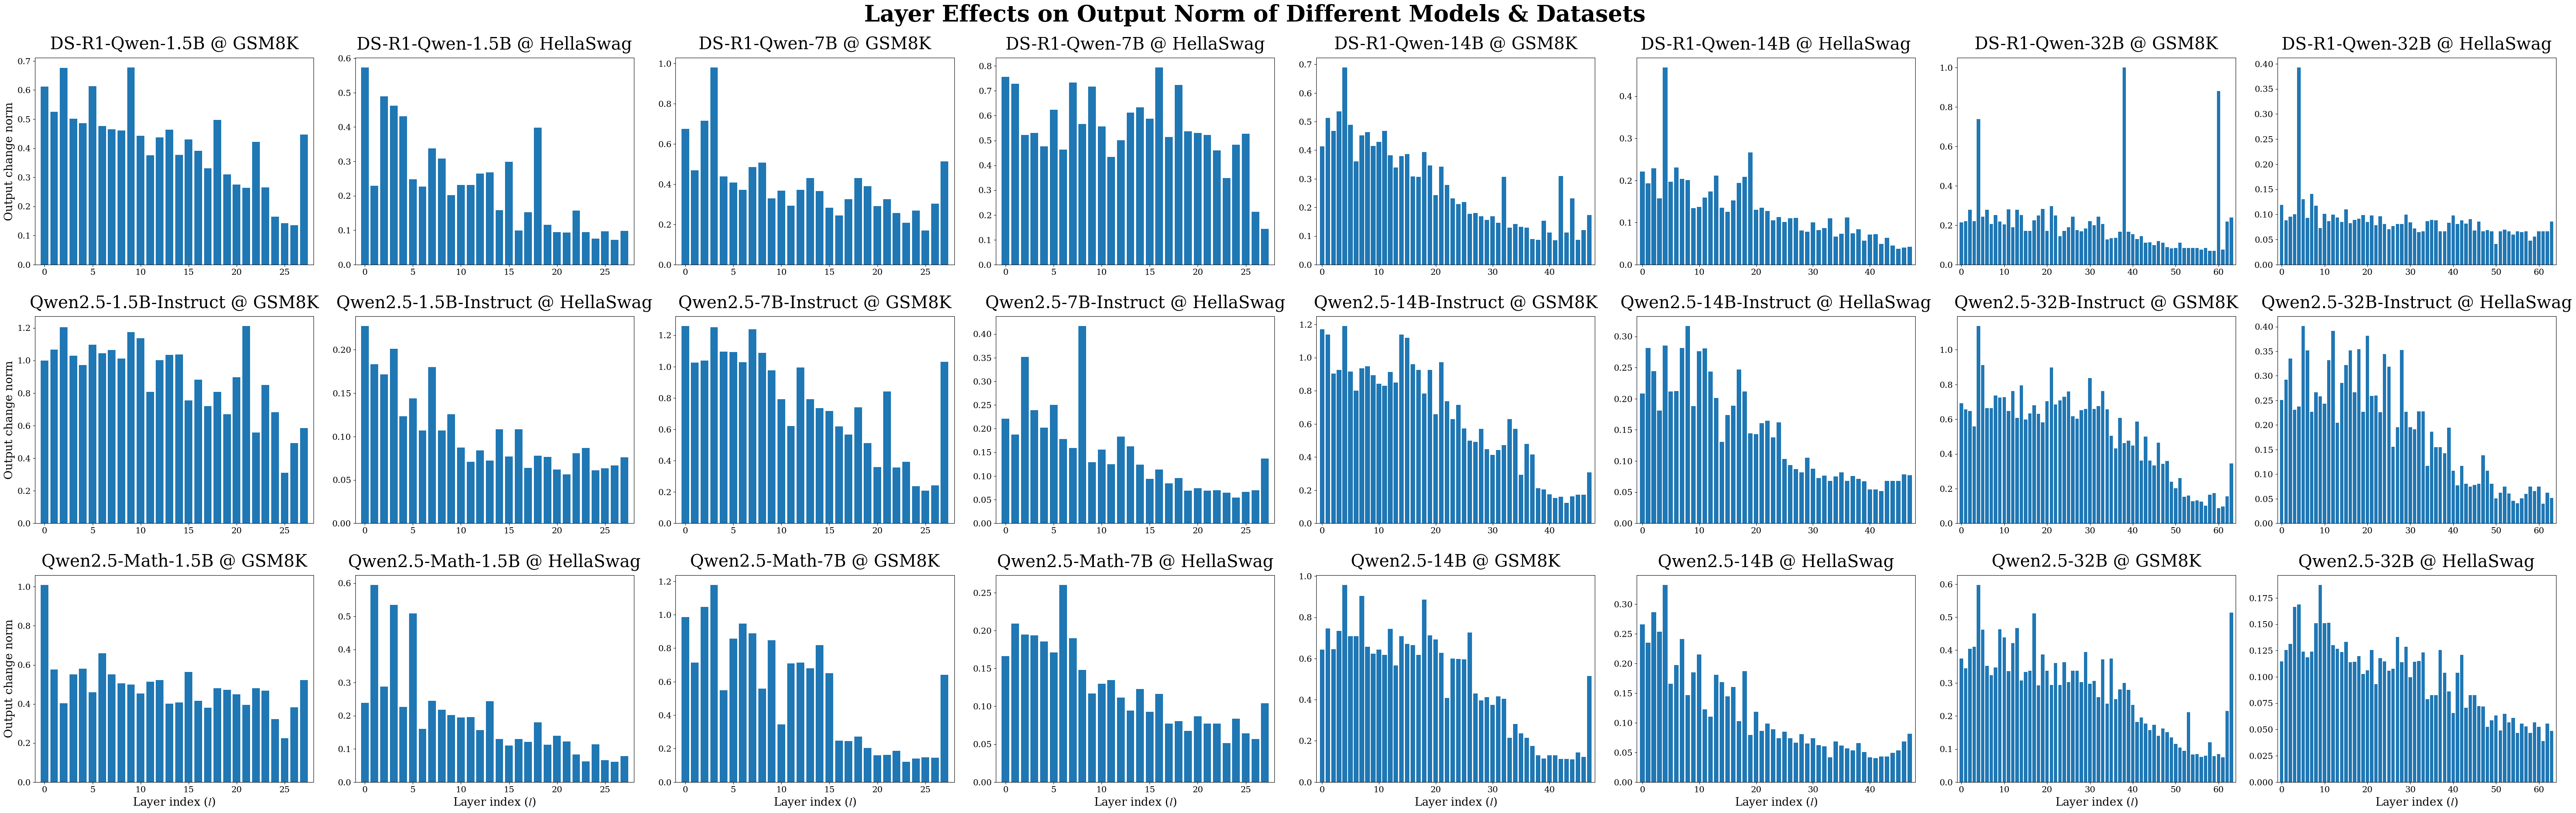

In [27]:
# Create figure for layer effects
fig_layer, axes_layer = plt.subplots(3, 8, figsize=(80, 22))
plt.subplots_adjust(
    top=0.92,
    hspace=0.25,
    wspace=0.15  # Increased for colorbar spacing
)

idx = 0
for model in models:
    for dataset in ["gsm8k", "hellaswag"]:
        if dataset == "gsm8k": 
            n_examples = 10
            vmin = 0
            vmax = 1
        else: 
            n_examples = 10
            vmin = 0
            vmax = 0.5
        model_path = f"outputs/{dataset}/{model}/layer_effects_{n_examples}exps.pt"
        data = torch.load(model_path)
        max_future_out = data["max_future_out"].squeeze()
        
        ax = axes_layer[idx//8, idx%8]
        
        ax.tick_params(axis='both', which='major', labelsize=15)
        
        ax.bar(range(len(max_future_out)), max_future_out.float().cpu().numpy())
        
        if model.startswith("DeepSeek-R1-Distill"):
            model_name = model.replace("DeepSeek-R1-Distill-", "DS-R1-")
        else:
            model_name = model
        if dataset == "gsm8k":
            dataset_name = "GSM8K"
        elif dataset == "hellaswag":
            dataset_name = "HellaSwag"
        
        ax.set_title(f"{model_name} @ {dataset_name}", pad=15, fontsize=30)
        
        ax.set_xlim(-1, len(max_future_out))
        
        if idx % 8 == 0:  # First column
            ax.set_ylabel("Output change norm", fontsize=20)
        if idx // 8 == 2:  # Last row
            ax.set_xlabel("Layer index ($l$)", fontsize=20)
        idx += 1
        
fig_layer.suptitle("Layer Effects on Output Norm of Different Models & Datasets", fontweight='bold', fontsize=40, y=0.98)
fig_layer.savefig("figures/gsm8k_hellaswag_layer_effects_output_norm.pdf", bbox_inches='tight', dpi=300)

## 3. Logit lens

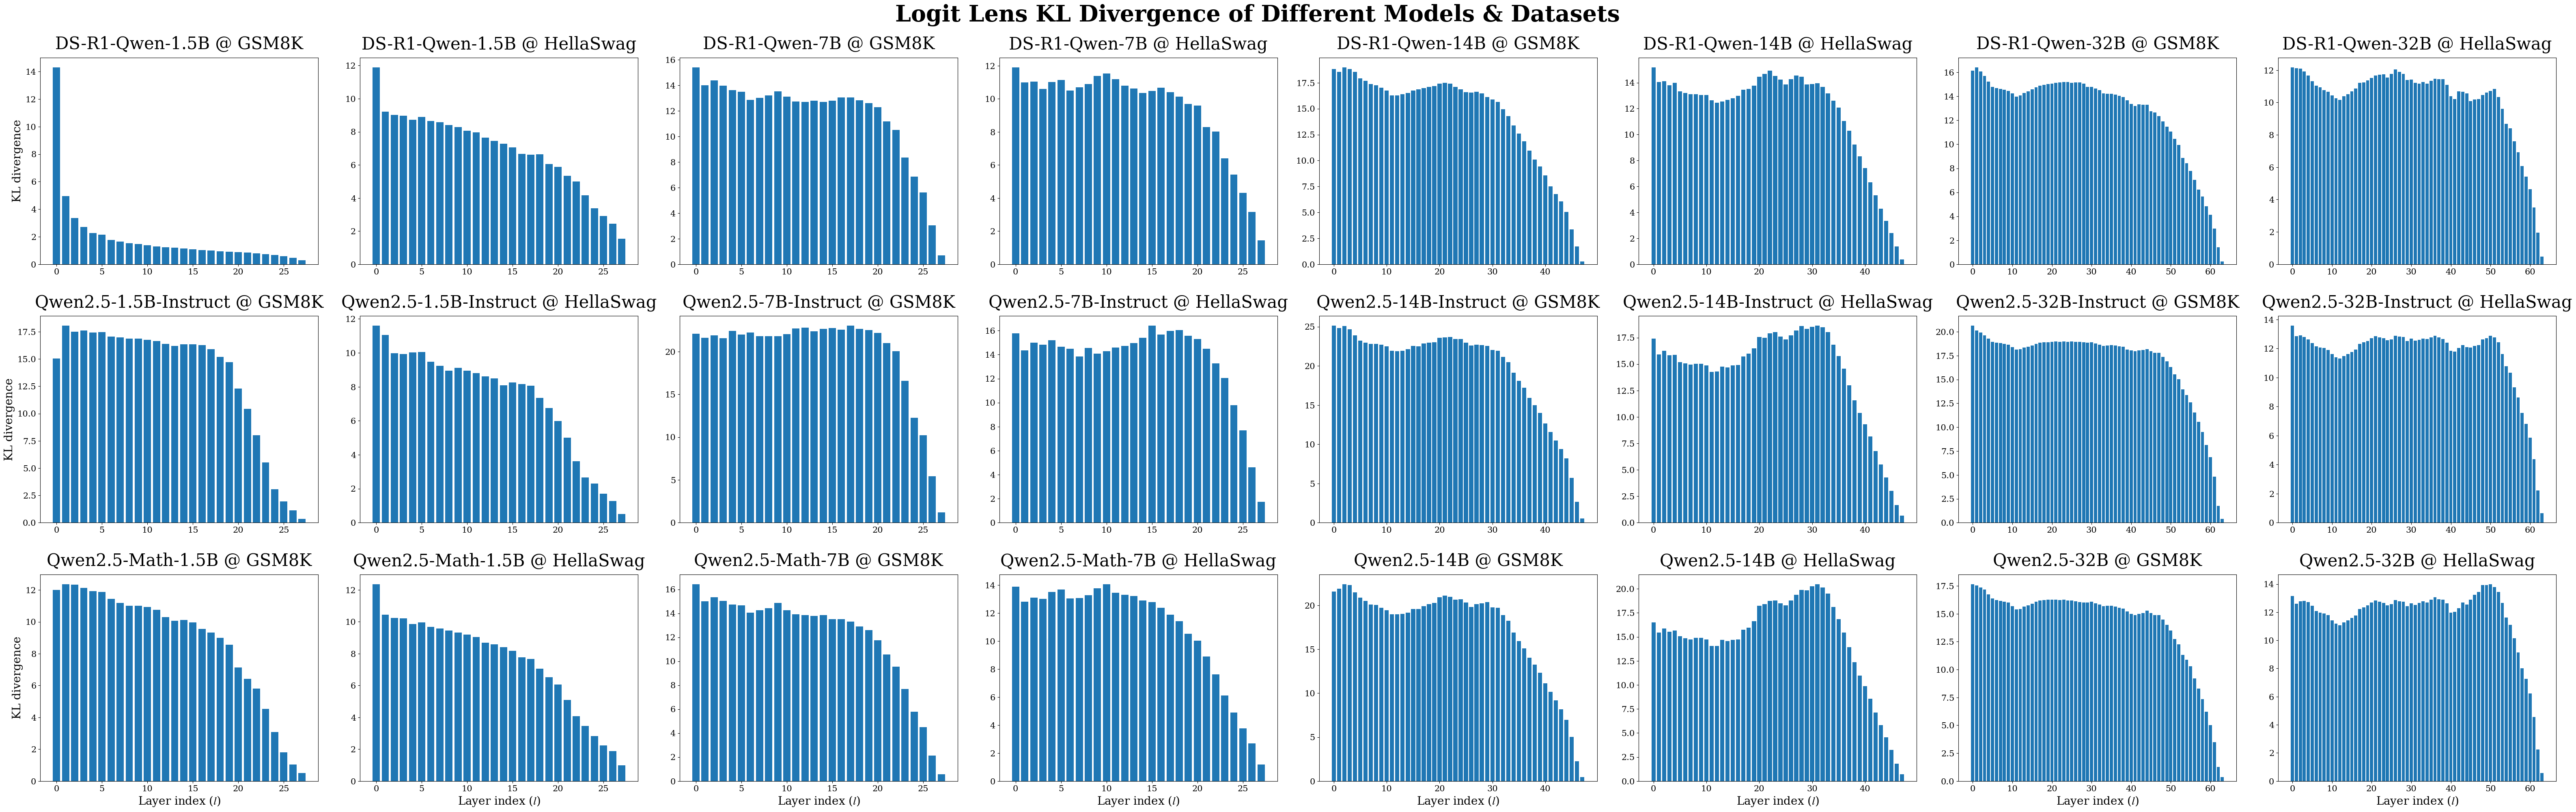

In [5]:
fig_kl, axes_kl = plt.subplots(3, 8, figsize=(80, 22))
plt.subplots_adjust(
    top=0.92,
    hspace=0.25,
    wspace=0.15  # Increased for colorbar spacing
)


idx = 0
for model in models:
    for dataset in ["gsm8k", "hellaswag"]:
    # Load data
        model_path = f"outputs/{dataset}/{model}/logitlens_10exps.pt"
        data = torch.load(model_path)
        res_kl_divs = data["res_kl_divs"]

        ax = axes_kl[idx//8, idx%8]
        
        ax.tick_params(axis='both', which='major', labelsize=15)

        # Plot bar chart
        ax.bar(range(len(res_kl_divs)), res_kl_divs.float().cpu().numpy())
        
        if model.startswith("DeepSeek-R1-Distill"):
            model_name = model.replace("DeepSeek-R1-Distill-", "DS-R1-")
        else:
            model_name = model
        if dataset == "gsm8k":
            dataset_name = "GSM8K"
        elif dataset == "hellaswag":
            dataset_name = "HellaSwag"
            
        ax.set_title(f"{model_name} @ {dataset_name}", pad=15, fontsize=30)
        
        if idx % 8 == 0:  # First column
            ax.set_ylabel("KL divergence", fontsize=20)
        if idx // 8 == 2:  # Last row
            ax.set_xlabel("Layer index ($l$)", fontsize=20)
        idx += 1


fig_kl.suptitle("Logit Lens KL Divergence of Different Models & Datasets", fontweight='bold', fontsize=40, y=0.98)
fig_kl.savefig("figures/gsm8k_hellaswag_logit_lens_kl_divergence.pdf", bbox_inches='tight', dpi=300)

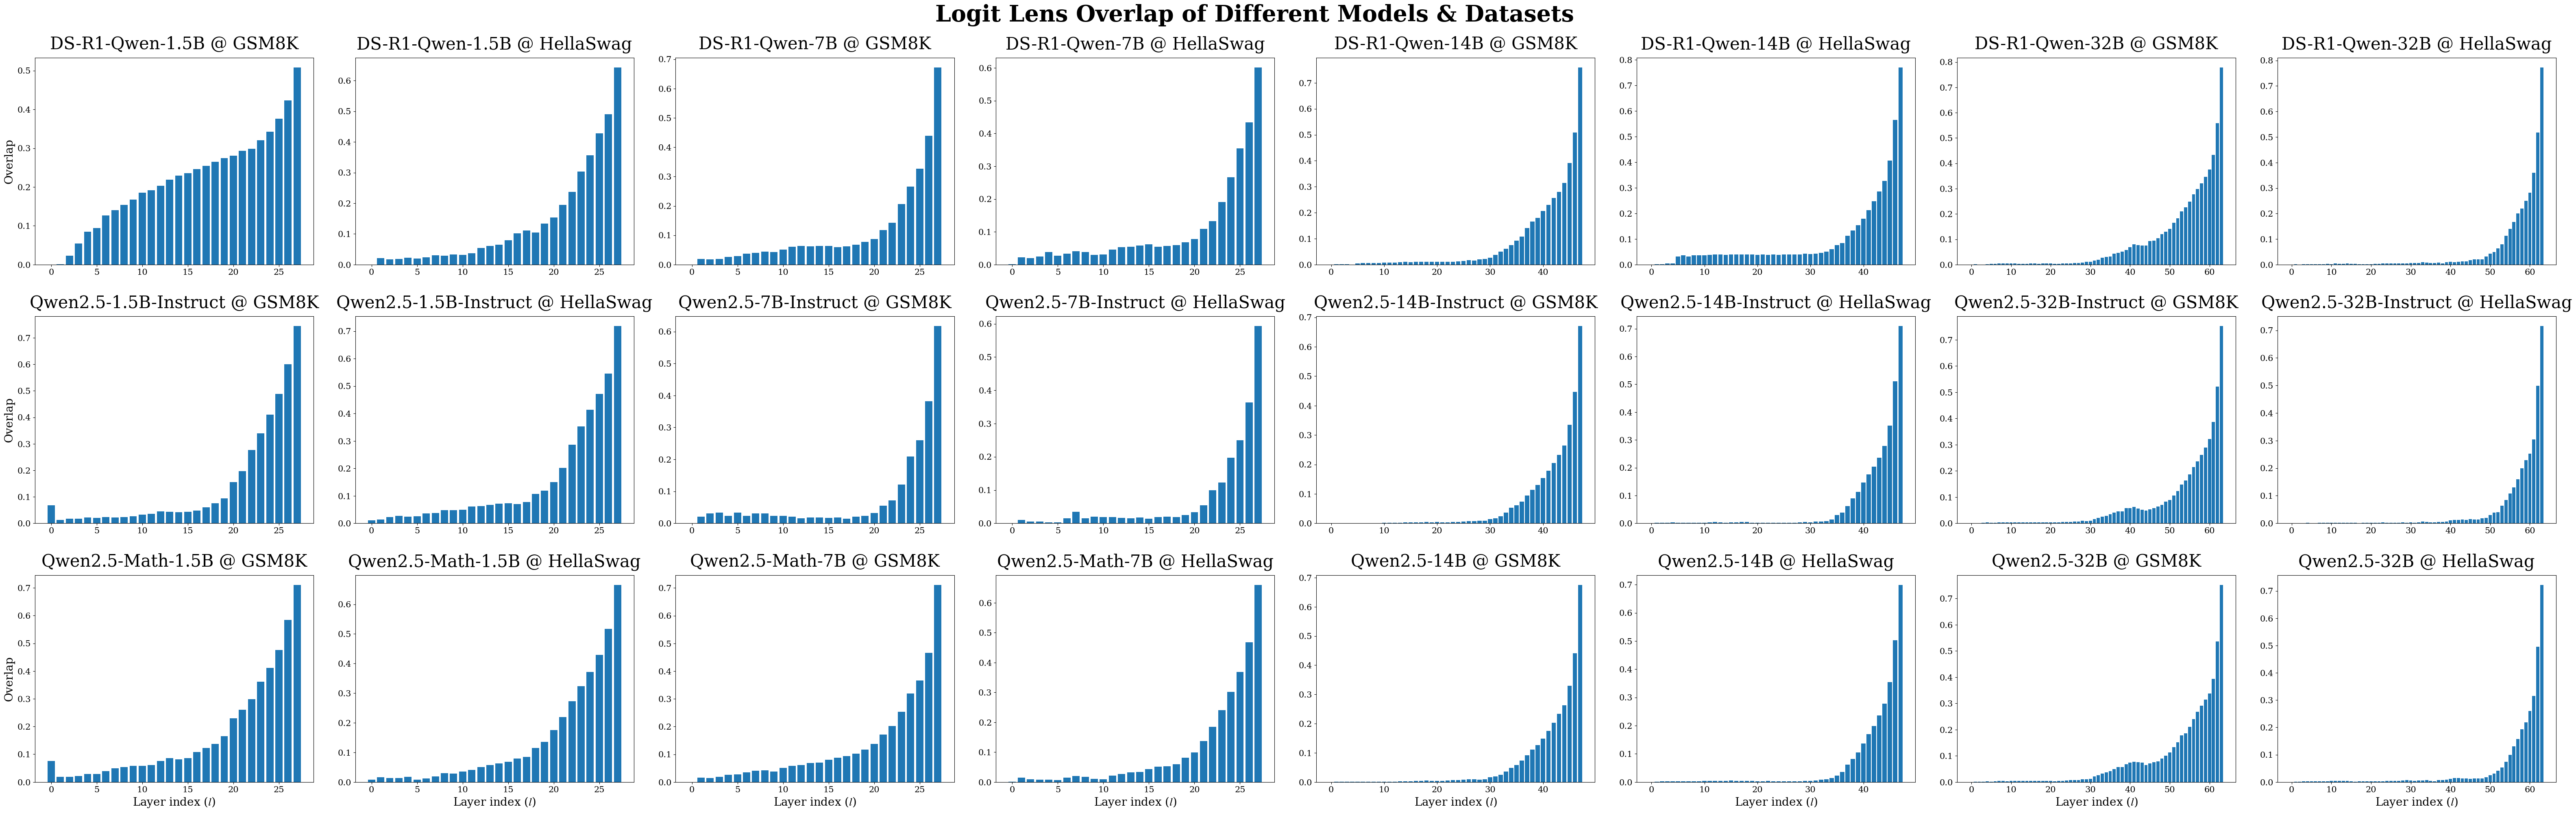

In [33]:
fig_kl, axes_kl = plt.subplots(3, 8, figsize=(80, 22))
plt.subplots_adjust(
    top=0.92,
    hspace=0.25,
    wspace=0.15  # Increased for colorbar spacing
)


idx = 0
for model in models:
    for dataset in ["gsm8k", "hellaswag"]:
    # Load data
        model_path = f"outputs/{dataset}/{model}/logitlens_10exps.pt"
        data = torch.load(model_path)
        res_overlaps = data["res_overlaps"]

        ax = axes_kl[idx//8, idx%8]

        ax.tick_params(axis='both', which='major', labelsize=15)
        if model.startswith("DeepSeek-R1-Distill"):
            model_name = model.replace("DeepSeek-R1-Distill-", "DS-R1-")
        else:
            model_name = model
        if dataset == "gsm8k":
            dataset_name = "GSM8K"
        elif dataset == "hellaswag":
            dataset_name = "HellaSwag"
            
        ax.set_title(f"{model_name} @ {dataset_name}", pad=15, fontsize=30)

        # Plot bar chart
        ax.bar(range(len(res_overlaps)), res_overlaps.float().cpu().numpy())
        if idx % 8 == 0:  # First column
            ax.set_ylabel("Overlap", fontsize=20)
        if idx // 8 == 2:  # Last row
            ax.set_xlabel("Layer index ($l$)", fontsize=20)
        idx += 1

fig_kl.suptitle("Logit Lens Overlap of Different Models & Datasets", fontweight='bold', fontsize=40, y=0.98)
fig_kl.savefig("figures/gsm8k_hellaswag_logit_lens_overlap.pdf", bbox_inches='tight', dpi=300)